In [140]:
import pandas as pd
import sklearn
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [141]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [142]:
train.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')

In [143]:
df = train.append(test).reset_index()

# Plotting Graph Function

In [144]:
def transported_chance_by(feature, xticks=None, xlim=None):
    transported = df[df.Transported == 1]
    not_transported = df[df.Transported == 0]

    plt.figure(figsize=(10, 5))

    transported[feature].plot(kind='kde', label='transported')
    not_transported[feature].plot(kind='kde', label='not_transported')
    
    plt.xlim(xlim)
    plt.xticks(xticks)
    plt.legend()
    plt.grid()
    plt.xlabel(feature)
    plt.show()

In [ ]:
df

## Expenses

`Total Expenses`: We take all expenses and of a user and add it, and add another column    `No expenses` which is a check if user has spent any money

In [145]:
expense_features = ["RoomService", "FoodCourt", "ShoppingMall", 'Spa', "VRDeck"]
def expense(df):
    df['Total_expense'] = df.loc[:,expense_features].sum(axis=1)
    df['No_expenses'] = (df['Total_expense']==0).astype(int)
    return df

## Group and Member Details


In [146]:
def group_details(df):
    split = df.PassengerId.str.split('_')
    group = [w[0] for w in split]
    memberNum = [w[1] for w in split]
    df['Group'] = group
    df['MemberNum'] = memberNum
    return df

## Room Details

In [147]:
def cabin_details(df):
    split = df.Cabin.str.split("/", expand=True)
    deck = split.iloc[:, 0]
    num = split.iloc[:, 1]
    side = split.iloc[:, 2]
    
    df['Deck'] = deck
    df['Num'] = num
    df['Side'] = side
    
    return df

## Cabin Region

In [148]:
def cabin_region(df):
    cabin_group = pd.cut(x=df.Num.astype('float'),
                      bins=[-10, 300, 600, 900, 1200, 1500, 1800, 1.e+10],
                      labels=['r1', 'r2', 'r3', 'r4', 'r5', 'r6', 'r7'])
    if 'Cabin_Region' in df.columns:
        df = df.drop('Cabin_Region', axis=1)
        df.insert(df.shape[1],'Cabin_Region', cabin_group)
    else:
        df.insert(df.shape[1],'Cabin_Region', cabin_group)
    return df

In [149]:
def prerpocess_df(df):
    df = expense(df)
    df = group_details(df)
    df = cabin_details(df)
    df = cabin_region(df)
    return df

In [150]:
df = prerpocess_df(df)

# Filling NA Values

In [151]:
def checkNull(df):
    plt.figure(figsize=(16,6))
    sns.heatmap(df.isna())
    print(df.isna().sum())

index               0
PassengerId         0
HomePlanet        288
CryoSleep         310
Cabin             299
Destination       274
Age               270
VIP               296
RoomService       263
FoodCourt         289
ShoppingMall      306
Spa               284
VRDeck            268
Name              294
Transported      4277
Total_expense       0
No_expenses         0
Group               0
MemberNum           0
Deck              299
Num               299
Side              299
Cabin_Region      299
dtype: int64


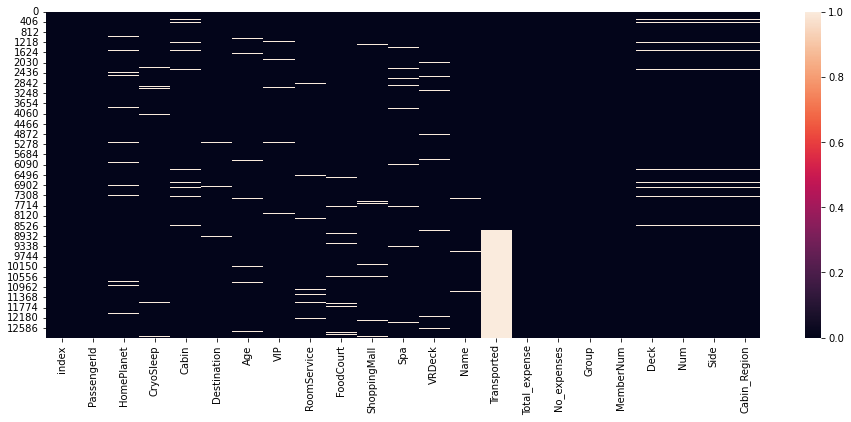

In [152]:
checkNull(df)

In [153]:
df.HomePlanet.isnull().sum()

288

#### The People from the same group will belong to the same HomePlanet, so we fill their values accordingly

In [154]:
def null_HomePlanet_Group(df):
    #get which group is from which planet
    group_homePlanet_map = {}
    for index, data in df.iterrows():
        if type(data.HomePlanet) == str:
            group_homePlanet_map[data.Group] = data.HomePlanet

    #fill na Groups with HomePlanet
    for index, data in df.iterrows():
        if type(data.HomePlanet) == float and data.Group in group_homePlanet_map:
            df.at[index, 'HomePlanet'] = group_homePlanet_map[data.Group]
    return df

In [155]:
df = null_HomePlanet_Group(df)

In [156]:
df.HomePlanet.isnull().sum()

157

In [157]:
df.groupby(['Deck'])['HomePlanet'].value_counts()

Deck  HomePlanet
A     Europa         352
B     Europa        1137
C     Europa        1096
D     Mars           410
      Europa         301
E     Earth          589
      Mars           515
      Europa         199
F     Earth         2437
      Mars          1742
G     Earth         3731
T     Europa          10
Name: HomePlanet, dtype: int64

`A, B, C, T` -> Europa and `G` -> Earth

In [158]:
def deck_HomePlanet(df):
    df.loc[(df['HomePlanet'].isna()) & (df['Deck'].isin(['A', 'B', 'C', 'T'])), 'HomePlanet'] = 'Europa'
    df.loc[(df['HomePlanet'].isna()) & (df['Deck']=='G'), 'HomePlanet'] = 'Earth'
    return df

In [159]:
df = deck_HomePlanet(df)

In [160]:
df.HomePlanet.isnull().sum()

94

In [161]:
df.groupby(['CryoSleep'])['No_expenses'].value_counts()

CryoSleep  No_expenses
False      0              7339
           1               740
True       1              4581
Name: No_expenses, dtype: int64

#### All people in CryoSleep dont spend any money, while as majority of awake people do

In [162]:
def CryoSleep_Expenses(df):
    df.loc[(df['CryoSleep'].isna()) & (df['No_expenses'] == 0), 'CryoSleep'] = False
    df.loc[(df['CryoSleep'].isna()) & (df['No_expenses'] == 1), 'CryoSleep'] = True
    return df

In [163]:
df = CryoSleep_Expenses(df)
df.CryoSleep.isna().sum()

0

In [164]:
import math
spaExpense = []
for w in df.Spa:
    if w > 0 and math.isnan(w) == False:
        spaExpense.append(1)
    else:
        if math.isnan(w) == False:
            spaExpense.append(0)
        else:
            spaExpense.append(float('nan'))
roomServiceExpense = []
for w in df.RoomService:
    if w > 0 and math.isnan(w) == False:
        roomServiceExpense.append(1)
    else:
        if math.isnan(w) == False:
            roomServiceExpense.append(0)
        else:
            roomServiceExpense.append(float('nan'))
foodCourtExpense = []
for w in df.FoodCourt:
    if w > 0 and math.isnan(w) == False:
        foodCourtExpense.append(1)
    else:
        if math.isnan(w) == False:
            foodCourtExpense.append(0)
        else:
            foodCourtExpense.append(float('nan'))
shoppingMallExpense = []
for w in df.ShoppingMall:
    if w > 0 and math.isnan(w) == False:
        shoppingMallExpense.append(1)
    else:
        if math.isnan(w) == False:
            shoppingMallExpense.append(0)
        else:
            shoppingMallExpense.append(float('nan'))
vrExpense = []
for w in df.VRDeck:
    if w > 0 and math.isnan(w) == False:
        vrExpense.append(1)
    else:
        if math.isnan(w) == False:
            vrExpense.append(0)
        else:
            vrExpense.append(float('nan'))
df['roomServiceExpense'] = roomServiceExpense
df['foodCourtExpense'] = foodCourtExpense
df['SpaExpense'] = spaExpense
df['shoppingMallExpense'] = shoppingMallExpense
df['vrExpense'] = vrExpense

In [165]:
df.VIP.value_counts()

False    12401
True       273
Name: VIP, dtype: int64

In [166]:
df.RoomService.sort_values(ascending=False).head(273)

4416     14327.0
9930     11567.0
5105      9920.0
8626      8586.0
7933      8243.0
          ...   
2683      2127.0
5057      2116.0
7051      2110.0
11260     2109.0
121       2103.0
Name: RoomService, Length: 273, dtype: float64

# 1. Majority of VIPs in (df.foodCourtExpense == 0.0) & (df.CryoSleep == True) & (df.VIP == True) are in No_expenses == 1
# 2. Other VIPs are (df.foodCourtExpense == 1.0) & (df.CryoSleep == False) df.HomePlanet is either Earth or Europa 

In [167]:
df.groupby(['foodCourtExpense','CryoSleep'],)['VIP'].value_counts()

foodCourtExpense  CryoSleep  VIP  
0.0               False      False    3402
                             True       68
                  True       False    4473
                             True       27
1.0               False      False    4248
                             True      172
Name: VIP, dtype: int64

In [168]:
df.groupby(['foodCourtExpense','CryoSleep'])['VIP'].value_counts()

foodCourtExpense  CryoSleep  VIP  
0.0               False      False    3402
                             True       68
                  True       False    4473
                             True       27
1.0               False      False    4248
                             True      172
Name: VIP, dtype: int64

In [169]:
df.groupby(['HomePlanet'])['VIP'].value_counts()

HomePlanet  VIP  
Earth       False    6804
Europa      False    2937
            True      178
Mars        False    2572
            True       91
Name: VIP, dtype: int64

In [170]:
df.VIP.isna().sum()

296

In [171]:
def fillVips(df):
    df.loc[(df.foodCourtExpense == 0.0) & (df.CryoSleep == True) & (df.VIP.isna()) & df.No_expenses == 1, 'VIP'] = True
    df.loc[(df.foodCourtExpense == 0.0) & (df.CryoSleep == True) & (df.HomePlanet == 'Mars') & (df.VIP.isna()), 'VIP'] = True
    df.loc[(df.foodCourtExpense == 0.0) & (df.CryoSleep == True) & (df.HomePlanet == 'Europa') & (df.VIP.isna()), 'VIP'] = True
    df.loc[(df.VIP.isna()), 'VIP'] = False
    return df

df = fillVips(df)

In [172]:
df.VIP.isna().sum()

0

In [173]:
df.VIP.value_counts()

False    12590
True       380
Name: VIP, dtype: int64

# Graph to see people who were transported with No_expenses

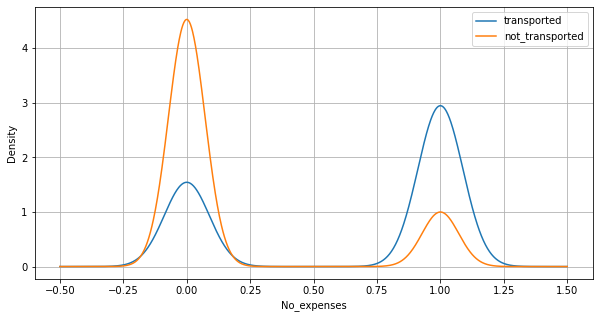

In [174]:
transported_chance_by('No_expenses')

## A lot of people who did not spend any money were transported

## All VIPs are from Europa or Mars

In [175]:
def HomePlanetVip(df):
    df.loc[(df.HomePlanet.isna()) & (df.VIP == False), 'HomePlanet'] = 'Earth'
    df.loc[(df.HomePlanet.isna()) & (df.VIP == True), 'HomePlanet'] = 'Europa'
    return df

df = HomePlanetVip(df)

# People in cryosleep can't spend money

In [176]:
def expensesNan(df):
    df.loc[(df.foodCourtExpense.isna()) & (df.CryoSleep == True), 'foodCourtExpense'] = 0.0
    df.loc[(df.shoppingMallExpense.isna()) & (df.CryoSleep == True), 'shoppingMallExpense'] = 0.0
    df.loc[(df.SpaExpense.isna()) & (df.CryoSleep == True), 'SpaExpense'] = 0.0
    df.loc[(df.roomServiceExpense.isna()) & (df.CryoSleep == True), 'roomServiceExpense'] = 0.0
    return df
df = expensesNan(df)

In [177]:
from nltk import FreqDist

def soloTravel(df):
    freq_dist = FreqDist(df.Group)
    solo = []
    for i in df.Group:
        if freq_dist[i] > 1:
            solo.append(0)
        else:
            solo.append(1)
    df['Solo'] = solo
    return df

df = soloTravel(df)

# Same group members may be going to same planet, if there is no data on Destination of Group then we impute it with TRAPPIST-1e

In [178]:
def GroupDest(df):
    group_Dest_map = {}
    for index, data in df.iterrows():
        if type(data.Destination) != float:
            group_Dest_map[data.Group] = data.Destination
        
    for index, data in df.iterrows():
        if type(data.Destination) == float and data.Group in group_Dest_map:
            df.loc[index, 'Destination'] = group_Dest_map[data.Group]
        else:
            df.loc[index, 'Destination'] = 'TRAPPIST-1e'
    return df

        
df = GroupDest(df)

index                     0
PassengerId               0
HomePlanet                0
CryoSleep                 0
Cabin                   299
Destination               0
Age                     270
VIP                       0
RoomService             263
FoodCourt               289
ShoppingMall            306
Spa                     284
VRDeck                  268
Name                    294
Transported            4277
Total_expense             0
No_expenses               0
Group                     0
MemberNum                 0
Deck                    299
Num                     299
Side                    299
Cabin_Region            299
roomServiceExpense      170
foodCourtExpense        179
SpaExpense              173
shoppingMallExpense     172
vrExpense               268
Solo                      0
dtype: int64


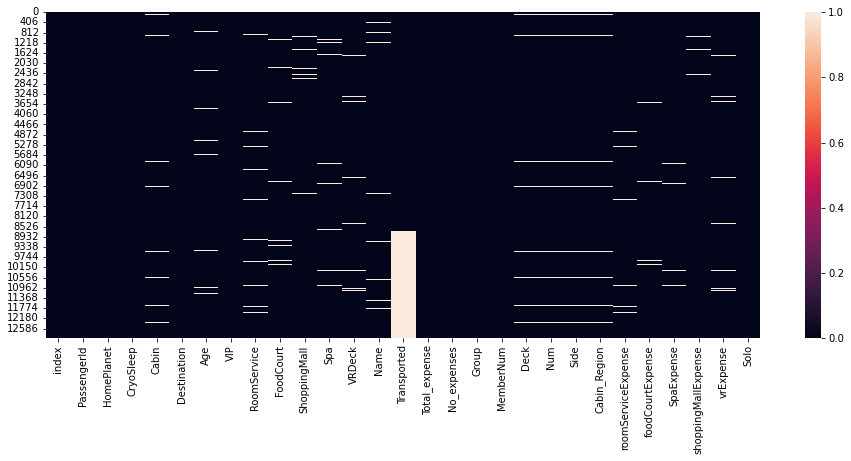

In [179]:
checkNull(df)

## People from same group might share same cabin region

index                     0
PassengerId               0
HomePlanet                0
CryoSleep                 0
Cabin                   299
Destination               0
Age                     270
VIP                       0
RoomService             263
FoodCourt               289
ShoppingMall            306
Spa                     284
VRDeck                  268
Name                    294
Transported            4277
Total_expense             0
No_expenses               0
Group                     0
MemberNum                 0
Deck                    299
Num                     299
Side                    299
Cabin_Region            299
roomServiceExpense      170
foodCourtExpense        179
SpaExpense              173
shoppingMallExpense     172
vrExpense               268
Solo                      0
dtype: int64


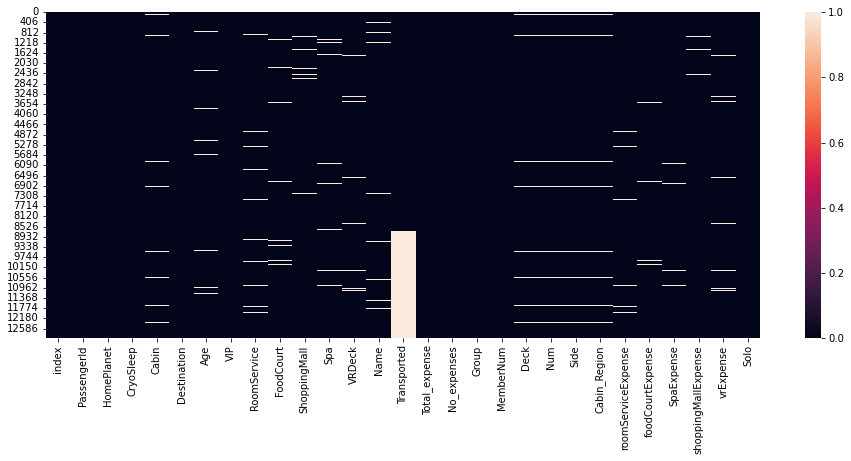

In [180]:
checkNull(df)

In [181]:
df.groupby('Solo')['Deck'].value_counts()

Solo  Deck
0     G       1537
      F       1482
      B        821
      C        732
      E        491
      D        377
      A        243
      T          3
1     F       2757
      G       2244
      E        832
      C        370
      D        343
      B        320
      A        111
      T          8
Name: Deck, dtype: int64

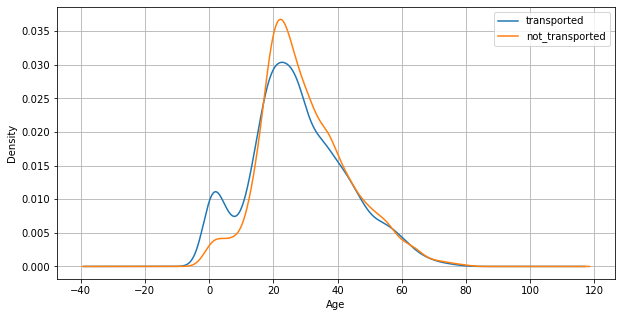

In [182]:
transported_chance_by('Age')

In [183]:
def lastName(df):
    splitName = df['Name'].str.split(" ", expand=True)
    lastName = splitName.iloc[:, 1]
    df['lastName'] = lastName
    return df

df = lastName(df)

# Impute Cabin Region with group since same group might share same Cabin Region and Same Last Name might share same cabin region since they might be together

In [184]:
def GroupCabin(df):
    group_Cabin_map = {}
    for index, data in df.iterrows():
        if type(data.Cabin_Region) != float:
            group_Cabin_map[data.Group] = data.Cabin_Region
        
    for index, data in df.iterrows():
        if type(data.Cabin_Region) == float and data.Group in group_Cabin_map:
            df.loc[index, 'Cabin_Region'] = group_Cabin_map[data.Group]
    return df

df = GroupDest(df)

In [185]:
def NameCabinRegion(df):
    group_Name_map = {}
    for index, data in df.iterrows():
        if type(data.Cabin_Region) != float:
            group_Name_map[data.Group] = data.Cabin_Region
        
    for index, data in df.iterrows():
        if type(data.Cabin_Region) == float and data.Group in group_Name_map:
            df.loc[index, 'Cabin_Region'] = group_Name_map[data.Group]
        else:
            df.loc[index, 'Cabin_Region'] = 'r1'
    return df

df = NameCabinRegion(df)

In [186]:
df.No_expenses

0        1
1        0
2        0
3        0
4        0
        ..
12965    1
12966    0
12967    1
12968    0
12969    1
Name: No_expenses, Length: 12970, dtype: int32

index                     0
PassengerId               0
HomePlanet                0
CryoSleep                 0
Cabin                   299
Destination               0
Age                     270
VIP                       0
RoomService             263
FoodCourt               289
ShoppingMall            306
Spa                     284
VRDeck                  268
Name                    294
Transported            4277
Total_expense             0
No_expenses               0
Group                     0
MemberNum                 0
Deck                    299
Num                     299
Side                    299
Cabin_Region              0
roomServiceExpense      170
foodCourtExpense        179
SpaExpense              173
shoppingMallExpense     172
vrExpense               268
Solo                      0
lastName                294
dtype: int64


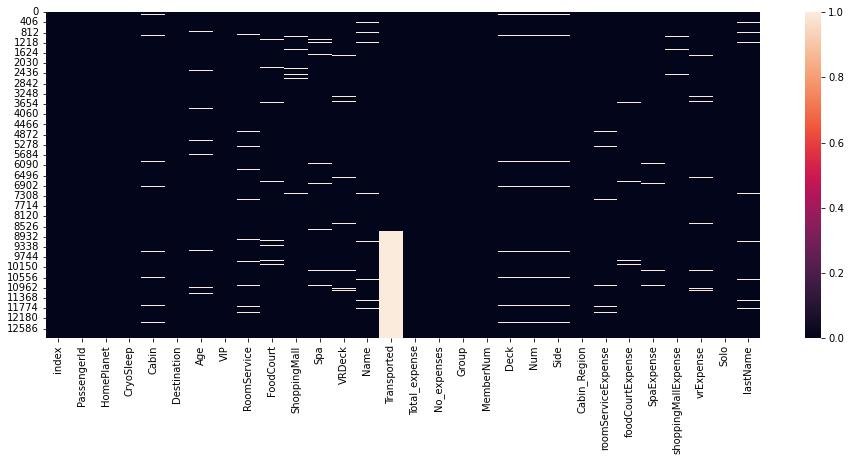

In [187]:
checkNull(df)

## In case we have a person who spends nothing, we impute all `_expenses` with 0.0

In [188]:
def no_expense(df):
    df.loc[df.roomServiceExpense.isna() & df.No_expenses == 1, 'roomServiceExpense'] = 0.0
    df.loc[df.shoppingMallExpense.isna() & df.No_expenses == 1, 'shoppingMallExpense'] = 0.0
    df.loc[df.SpaExpense.isna() & df.No_expenses == 1, 'SpaExpense'] = 0.0
    df.loc[df.vrExpense.isna() & df.No_expenses == 1, 'vrExpense'] = 0.0
    df.loc[df.foodCourtExpense.isna() & df.No_expenses == 1, 'foodCourtExpense'] = 0.0
    df.loc[df.roomServiceExpense.isna() & df.No_expenses == 0, 'roomServiceExpense'] = 1.0
    df.loc[df.shoppingMallExpense.isna() & df.No_expenses == 0, 'shoppingMallExpense'] = 1.0
    df.loc[df.SpaExpense.isna() & df.No_expenses == 0, 'SpaExpense'] = 1.0
    df.loc[df.vrExpense.isna() & df.No_expenses == 0, 'vrExpense'] = 1.0
    df.loc[df.foodCourtExpense.isna() & df.No_expenses == 0, 'foodCourtExpense'] = 1.0
    
    return df

In [189]:
df = no_expense(df)

index                     0
PassengerId               0
HomePlanet                0
CryoSleep                 0
Cabin                   299
Destination               0
Age                     270
VIP                       0
RoomService             263
FoodCourt               289
ShoppingMall            306
Spa                     284
VRDeck                  268
Name                    294
Transported            4277
Total_expense             0
No_expenses               0
Group                     0
MemberNum                 0
Deck                    299
Num                     299
Side                    299
Cabin_Region              0
roomServiceExpense        0
foodCourtExpense          0
SpaExpense                0
shoppingMallExpense       0
vrExpense                 0
Solo                      0
lastName                294
dtype: int64


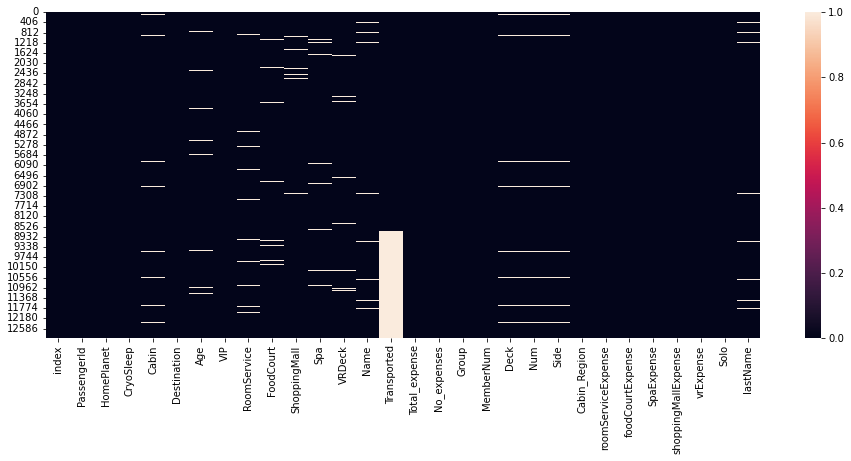

In [190]:
checkNull(df)

## Binning Age
Categorized the users into age group

In [191]:
def Age(df):    
    df.loc[((df.VIP == True) & df.Age.isna()), 'Age'] = df.loc[(df.VIP == True), 'Age'].median()

    # Impute median Age for people that have expenses
    df.loc[(df.Age.isna() 
            & df.Total_expense.gt(0)), 'Age'] = df.loc[df.Total_expense.gt(0), 'Age'].median()

    # Impute median Age for people with no expenses and not in CryoSleep
    df.loc[(df.Age.isna() 
            & df.Total_expense.eq(0)
            & df.CryoSleep.eq(False)), 'Age'] = df.loc[(df.Total_expense.eq(0) 
                                                        & df.CryoSleep.eq(False)), 'Age'].median()

    # Impute an overall median Age for people not included in previous groups
    df.Age.fillna(df.Age.median(), inplace=True)
    
    return df

df = Age(df)

In [192]:
def age_group(df):
    age_group = pd.cut(x=df.Age.astype(float),
                      bins=[-1, 12, 18, 25, 30, 50, 1.e+10],
                      labels=['g_0-12', 'g_13-17', 'g_18-25', 'g_26-30', 'g_31-50', 'g_51+'])
    
    df.insert(df.shape[1],'Age_Group', age_group)
    return df

df = age_group(df)

# Side as a different category for Null values

In [193]:
def side_na(df):
    df.loc[df.Side.isna(), 'Side'] = 'N'
    return df

df = side_na(df)

# Imputing Deck Null values using RFs Based on Group

In [194]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
def impute_deck(df):
    X_train=df.loc[~(df['Deck'].isna()),['Group']]
    y_train=df.loc[~(df['Deck'].isna()),'Deck']
    X_test=df.loc[(df['Deck'].isna()),['Group']]

    model=RandomForestClassifier()
    model.fit(X_train.values.reshape(-1, 1), y_train)
    preds=model.predict(X_test.values.reshape(-1, 1))
    # Fill missing values with predictions
    df.loc[(df['Deck'].isna()),'Deck']=preds
    return df

df = impute_deck(df)

index                     0
PassengerId               0
HomePlanet                0
CryoSleep                 0
Cabin                   299
Destination               0
Age                       0
VIP                       0
RoomService             263
FoodCourt               289
ShoppingMall            306
Spa                     284
VRDeck                  268
Name                    294
Transported            4277
Total_expense             0
No_expenses               0
Group                     0
MemberNum                 0
Deck                      0
Num                     299
Side                      0
Cabin_Region              0
roomServiceExpense        0
foodCourtExpense          0
SpaExpense                0
shoppingMallExpense       0
vrExpense                 0
Solo                      0
lastName                294
Age_Group                 0
dtype: int64


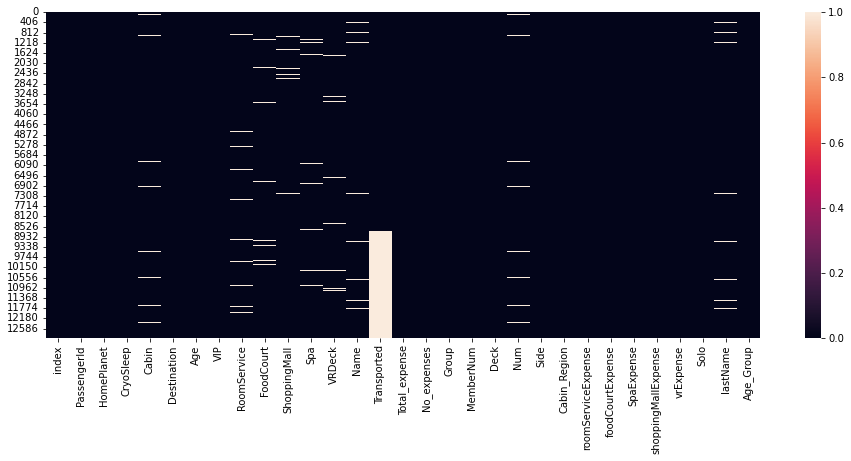

In [195]:
checkNull(df)

In [196]:
from sklearn.ensemble import RandomForestRegressor
def impute_num(df):
    for deck in ['A', 'B', 'C', 'D', 'E', 'F', 'G']:
        
        X_deck=df.loc[~(df['Num'].isna()) & (df['Deck']==deck),'Group']
        y_deck=df.loc[~(df['Num'].isna()) & (df['Deck']==deck),'Num']
        X_test_deck=df.loc[(df['Num'].isna()) & (df['Deck']==deck),'Group']

        
        model=RandomForestRegressor()
        model.fit(X_deck.values.reshape(-1, 1), y_deck)
        preds=model.predict(X_test_deck.values.reshape(-1, 1))

        # Fill missing values with predictions
        df.loc[(df['Num'].isna()) & (df['Deck']==deck),'Num']=preds.astype(int)
    return df

df = impute_num(df)

In [197]:
df.Num.mode()

0    82
dtype: object

In [198]:
df.loc[df.Num.isna(), 'Num'] = '0'

index                     0
PassengerId               0
HomePlanet                0
CryoSleep                 0
Cabin                   299
Destination               0
Age                       0
VIP                       0
RoomService             263
FoodCourt               289
ShoppingMall            306
Spa                     284
VRDeck                  268
Name                    294
Transported            4277
Total_expense             0
No_expenses               0
Group                     0
MemberNum                 0
Deck                      0
Num                       0
Side                      0
Cabin_Region              0
roomServiceExpense        0
foodCourtExpense          0
SpaExpense                0
shoppingMallExpense       0
vrExpense                 0
Solo                      0
lastName                294
Age_Group                 0
dtype: int64


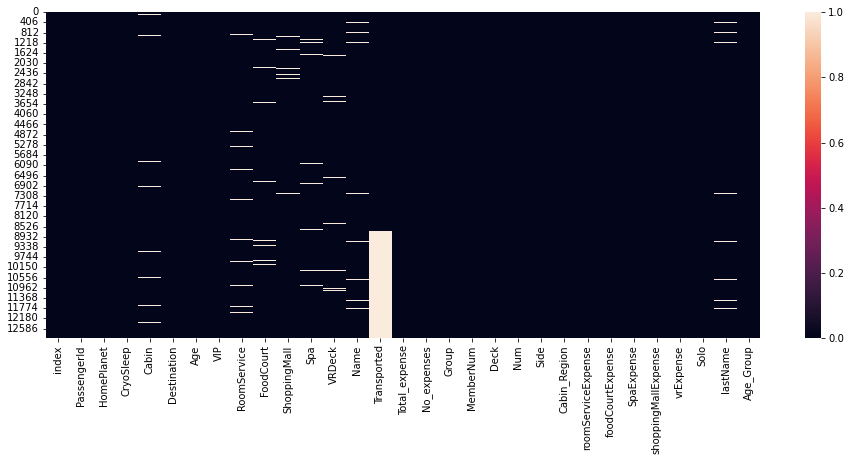

In [199]:
checkNull(df)

# Dropping Irrelevant Columns

In [200]:
def dropping_cols(df):
    drop_columns = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Name', 'lastName', 'Cabin', 'index', 'PassengerId', 'MemberNum']
    df = df.drop(drop_columns, axis=1)
    return df

df = dropping_cols(df)

# Creating Deck / Transported Ratio

In [201]:
deck_total = df.groupby('Deck').Deck.count()
deck_total_transported = df.groupby('Deck').Transported.sum()
deck_transp_ratio = (deck_total_transported / deck_total).to_dict()
deck_transp_ratio
df['Deck_transp_ratio'] = df.Deck.map(deck_transp_ratio)

In [202]:
side = df.groupby('Side').Deck.count()
side_transported = df.groupby('Side').Transported.sum()
side_transported_ratio = (side_transported/side).to_dict()
side_transported_ratio
df['Side_transp_ratio'] = df.Side.map(side_transported_ratio)

# Preparing X and Y

In [203]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12970 entries, 0 to 12969
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   HomePlanet           12970 non-null  object  
 1   CryoSleep            12970 non-null  object  
 2   Destination          12970 non-null  object  
 3   Age                  12970 non-null  float64 
 4   VIP                  12970 non-null  object  
 5   Transported          8693 non-null   object  
 6   Total_expense        12970 non-null  float64 
 7   No_expenses          12970 non-null  int32   
 8   Group                12970 non-null  object  
 9   Deck                 12970 non-null  object  
 10  Num                  12970 non-null  object  
 11  Side                 12970 non-null  object  
 12  Cabin_Region         12970 non-null  category
 13  roomServiceExpense   12970 non-null  float64 
 14  foodCourtExpense     12970 non-null  float64 
 15  SpaExpense         

In [204]:
numerical_cols = ['Deck_transp_ratio', 'Side_transp_ratio', 'roomServiceExpense', 
                  'foodCourtExpense', 'SpaExpense', 'shoppingMallExpense', 'vrExpense',
                  'Solo', 'No_expenses', 'Age']
categorical_cols = ['HomePlanet', 'CryoSleep', 'Destination',
                    'Cabin_Region', 'Deck', 'Side', 'VIP']
target = 'Transported'

# Train Test Split Code

In [205]:
from sklearn.preprocessing import StandardScaler
ohe = OneHotEncoder(drop='if_binary', sparse=False)
ss = StandardScaler()

In [206]:
y = df[df['Transported'].notnull()].copy()
y = y['Transported'].map({True: 1, False: 0})

In [207]:
df_ohe = ohe.fit_transform(df[categorical_cols])
numerical_cols_std_scaled = ss.fit_transform(df[numerical_cols])
X_cat = pd.DataFrame(df_ohe, columns=ohe.get_feature_names_out())
X_num = pd.DataFrame(numerical_cols_std_scaled, columns=numerical_cols)
X = pd.concat([X_cat, X_num], axis=1)

C:\Users\shvmt\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [208]:
X_TEST = X[df['Transported'].isnull()].copy()
X = X[df['Transported'].notnull()].copy()

HomePlanet_Earth           0
HomePlanet_Europa          0
HomePlanet_Mars            0
CryoSleep_True             0
Destination_TRAPPIST-1e    0
Cabin_Region_r1            0
Cabin_Region_r2            0
Cabin_Region_r3            0
Cabin_Region_r4            0
Cabin_Region_r5            0
Cabin_Region_r6            0
Cabin_Region_r7            0
Deck_A                     0
Deck_B                     0
Deck_C                     0
Deck_D                     0
Deck_E                     0
Deck_F                     0
Deck_G                     0
Deck_T                     0
Side_N                     0
Side_P                     0
Side_S                     0
VIP_True                   0
Deck_transp_ratio          0
Side_transp_ratio          0
roomServiceExpense         0
foodCourtExpense           0
SpaExpense                 0
shoppingMallExpense        0
vrExpense                  0
Solo                       0
No_expenses                0
Age                        0
dtype: int64


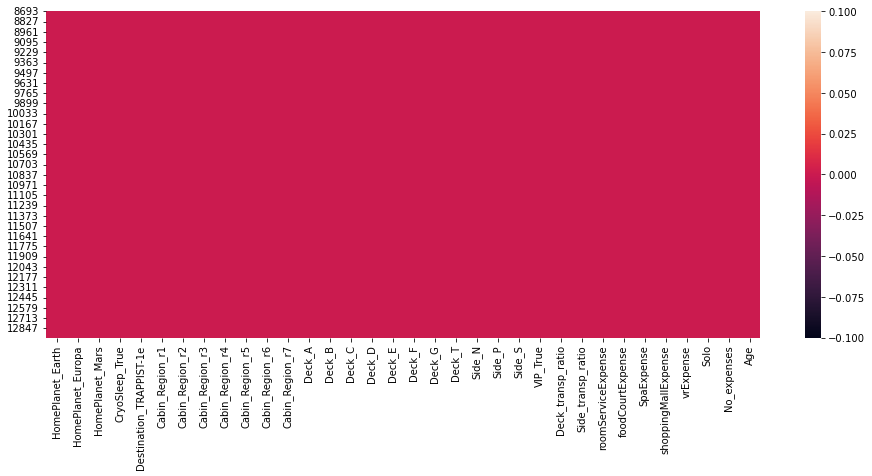

In [209]:
checkNull(X_TEST)

In [211]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [212]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
model1 = LGBMClassifier()
parameters1 = {"n_estimators":[100,300,500,600,650],
              "learning_rate":[0.01,0.02,0.03],
              "random_state":[0,42,48,50],
               "num_leaves":[16,17,18]}
grid_search1 = GridSearchCV(model1, parameters1, cv=5, n_jobs=-1)
grid_search1.fit(X,y.values.ravel())
grid_search1.best_score_
best_parameters1 = grid_search1.best_params_
model1 = LGBMClassifier(**best_parameters1)
model1.fit(X_train,y_train)

LGBMClassifier(learning_rate=0.01, n_estimators=300, num_leaves=16,
               random_state=0)

In [213]:
y_pred = model1.predict(X_test)
from sklearn.metrics import accuracy_score
accuracy_score(y_pred, y_test)

0.7404141104294478

In [214]:
model2 = LGBMClassifier(**best_parameters1)
model2.fit(X,y)
y_pred2 = model2.predict(X_TEST)

# Creating Submission

In [215]:
sample = pd.read_csv('sample_submission.csv')

In [216]:
sample['Transported'] = y_pred2

In [217]:
sample['Transported']=sample['Transported']>0.5

In [218]:
sample.to_csv('submission.csv', index=False)

In [224]:
!pip install optuna

In [231]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import lightgbm as lgb
from lightgbm import LGBMClassifier
import optuna.study as optuna_study
import optuna.study as LGBM_study
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=10)
def objective(trial):
    param = {
     'objective': 'binary',
     'device': 'cpu',
     'metric': 'binary_logloss',
     'verbosity': -1,
     'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0),
     'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0),
     'learning_rate': trial.suggest_float('learning_rate', 0.0001,0.1),
     'num_leaves': trial.suggest_int('num_leaves', 2, 512),
     'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
     'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
     'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
     'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
     'n_estimators' : trial.suggest_int('n_estimators', 100, 20000),
     'subsample':None,
     'subsample_freq':None,
     'reg_alpha':None,
     'colsample_bytree':None,
     'reg_lambda':None,
     'early_stopping_round':trial.suggest_int('early_stopping_round', 200, 200)
            }
    results=[]
    n_iterations=[]
    for train_index, test_index in skf.split(X, y):
        train_X, valid_X = X.iloc[train_index], X.iloc[test_index]
        train_y, valid_y = y.iloc[train_index], y.iloc[test_index]
        model = lgb.LGBMClassifier(**param).fit(train_X,train_y,
                                            eval_set=[(valid_X,valid_y)],
                                            callbacks=[lgb.log_evaluation(period=0, show_stdv=False)]
                                             )  
        n_iteration = model.best_iteration_
        n_iterations.append(n_iteration)
        result = accuracy_score(valid_y,(model.predict(valid_X)))
        results.append(result)
    n=sum(results)/len(results)
    return n

if optuna_study == LGBM_study:
    study = optuna.create_study(pruner=optuna.pruners.HyperbandPruner(),
                                direction='maximize')
    study.optimize(objective, n_trials=10000)
    print('Best trial:', study.best_trial.params)

[I 2023-02-26 15:52:10,647] A new study created in memory with name: no-name-2acafe0c-f861-4dc8-b19a-991da3ff78e2


In [ ]:
# After Running the above code for 2 hours , we got the following best parameter values
params_LGBM= {'lambda_l1': 6.183557865875619, 
              'lambda_l2': 0.011470762415538793, 
              'learning_rate': 0.08693013162698361, 
              'num_leaves': 330,
              'feature_fraction': 0.6583455294128855, 
              'bagging_fraction': 0.8666491286986552, 
              'bagging_freq': 1, 
              'min_child_samples': 17, 
              'n_estimators': 739}

In [233]:
import lightgbm as lgb
from lightgbm import LGBMClassifier
import optuna
import optuna.study as optuna_study
import optuna.study as XGB_study
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=10)
import xgboost as xgb
def objective(trial):
    param = {  
        'tree_method':'hist',
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'lambda': trial.suggest_float('lambda', 0, 10.0),
        'alpha': trial.suggest_float('alpha', 0, 10.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1,1.0),
        'subsample': trial.suggest_float('subsample', 0.2,1.0),
        'learning_rate': trial.suggest_float('learning_rate', 0.0001,0.1),
        'n_estimators': trial.suggest_int('n_estimators', 100,3000),
        'max_depth': trial.suggest_categorical('max_depth', [2,3,4,5,6,7,8,9,10]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'num_parallel_tree': trial.suggest_int('num_parallel_tree',1,1),
        #'early_stopping_rounds':200,
        }
    
    results=[]
    n_iterations=[]
    for train_index, test_index in skf.split(X, y):
        train_X, valid_X = X.iloc[train_index], X.iloc[test_index]
        train_y, valid_y = y.iloc[train_index], y.iloc[test_index]
        model = xgb.XGBClassifier(**param).fit(train_X,train_y,
                                      eval_set=[(valid_X,valid_y)],
                                      verbose=0
                                     )  
        n_iteration = model.get_booster().best_iteration
        n_iterations.append(n_iteration)
        result = accuracy_score(valid_y,(model.predict(valid_X)))
        results.append(result)
        i=int(sum(n_iterations)/len(n_iterations))  
    n=sum(results)/len(results) 
    return n

if optuna_study == XGB_study:
    study = optuna.create_study(pruner=optuna.pruners.HyperbandPruner(),
                                direction='maximize')
    study.optimize(objective, n_trials=1000)

[I 2023-02-26 16:55:43,900] A new study created in memory with name: no-name-80fe0be1-c03d-425f-ae7c-cdb9942f50d2
[I 2023-02-26 16:55:48,197] Trial 0 finished with value: 0.7414037802732696 and parameters: {'lambda': 2.242460285491469, 'alpha': 5.918106239385916, 'colsample_bytree': 0.15254492683116452, 'subsample': 0.9161876941286666, 'learning_rate': 0.026923498471526832, 'n_estimators': 466, 'max_depth': 2, 'min_child_weight': 2, 'num_parallel_tree': 1}. Best is trial 0 with value: 0.7414037802732696.
[I 2023-02-26 16:56:10,371] Trial 1 finished with value: 0.7453150007274842 and parameters: {'lambda': 2.060102515065271, 'alpha': 2.2431527450605704, 'colsample_bytree': 0.5535212964797681, 'subsample': 0.924205506224131, 'learning_rate': 0.03622997848430632, 'n_estimators': 2505, 'max_depth': 2, 'min_child_weight': 7, 'num_parallel_tree': 1}. Best is trial 1 with value: 0.7453150007274842.
[I 2023-02-26 16:56:17,953] Trial 2 finished with value: 0.7382984802190389 and parameters: {'l

[I 2023-02-26 17:02:07,145] Trial 20 finished with value: 0.7455452825946061 and parameters: {'lambda': 6.590104910979384, 'alpha': 4.4232346196817325, 'colsample_bytree': 0.8698886740128533, 'subsample': 0.4146893521792452, 'learning_rate': 0.015802356297230147, 'n_estimators': 125, 'max_depth': 10, 'min_child_weight': 4, 'num_parallel_tree': 1}. Best is trial 12 with value: 0.7485365660092854.
[I 2023-02-26 17:02:49,146] Trial 21 finished with value: 0.7472714045738925 and parameters: {'lambda': 8.670656328997003, 'alpha': 0.6151552265103484, 'colsample_bytree': 0.9839891886437632, 'subsample': 0.6187125266249024, 'learning_rate': 0.0027924815186811305, 'n_estimators': 1706, 'max_depth': 8, 'min_child_weight': 1, 'num_parallel_tree': 1}. Best is trial 12 with value: 0.7485365660092854.
[I 2023-02-26 17:03:33,578] Trial 22 finished with value: 0.7489979233628297 and parameters: {'lambda': 8.938781271438447, 'alpha': 1.339270391069452, 'colsample_bytree': 0.9091338928584481, 'subsample

KeyboardInterrupt: 

In [234]:
study = optuna.create_study(direction='maximize', study_name='XGBoost Optimization')
study.optimize(objective, n_trials=100)

# Print the best hyperparameters and their objective value
print("Best hyperparameters: ", study.best_params)
print("Best objective value: ", study.best_value)

[I 2023-02-26 17:10:21,668] A new study created in memory with name: XGBoost Optimization
[W 2023-02-26 17:10:29,519] Trial 0 failed with parameters: {'lambda': 0.07458116707082074, 'alpha': 4.512022272201987, 'colsample_bytree': 0.5755938234533018, 'subsample': 0.9627850967134874, 'learning_rate': 0.053617045732179965, 'n_estimators': 891, 'max_depth': 3, 'min_child_weight': 5, 'num_parallel_tree': 1} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\shvmt\AppData\Local\Temp/ipykernel_23932/1238527996.py", line 31, in objective
    model = xgb.XGBClassifier(**param).fit(train_X,train_y,
  File "C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py", line 506, in inner_f
    return f(**kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py", line 1250, in fit
    self._

KeyboardInterrupt: 

In [235]:
params_XGB_best= {'lambda': 3.0610042624477543, 
             'alpha': 4.581902571574289, 
             'colsample_bytree': 0.9241969052729379, 
             'subsample': 0.9527591724824661, 
             'learning_rate': 0.06672065863100594, 
             'n_estimators': 730, 
             'max_depth': 5, 
             'min_child_weight': 1, 
             'num_parallel_tree': 1}

In [236]:
pred_XGB_best = (xgb.XGBClassifier(**params_XGB_best).fit(X,y)).predict(test)
sample['Transported'] = pred_XGB_best
sample['Transported']=sample['Transported']>0.5
sample.to_csv('XGB_best(2).csv', index=False)

[17:10:43] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


ValueError: Feature shape mismatch, expected: 34, got 13

In [ ]:
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
lgbm = LGBMRegressor()
xgb = XGBRegressor()
lgbm_params = params_LGBM
xgb_params = params_XGB_best

lgbm_best_params = params_LGBM
xgb_best_params = params_XGB_best

lgbm_best = LGBMRegressor(**lgbm_best_params)
xgb_best = XGBRegressor(**xgb_best_params)
ensemble = VotingRegressor([('lgbm', lgbm_best), ('xgb', xgb_best)])
ensemble.fit(X, y)
y_pred = ensemble.predict(test)

In [ ]:
pred_XGB_best = (xgb.XGBClassifier(**params_XGB_best).fit(X,y)).predict(test)
sample['Transported'] = pred_XGB_best
sample['Transported']=sample['Transported']>0.5
sample.to_csv('XGB_best(2).csv', index=False)